# Setup

In [1]:
import scanpy as sc
import scvi
import os
import shutil
import anndata as ad
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
from ipywidgets import *
import warnings
import scrublet as scr

Global seed set to 0


In [2]:
sc.set_figure_params(figsize=(4,4),  dpi=150, dpi_save=300, facecolor="white", frameon=False)
plt.rcParams["axes.grid"] = False
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
os.getcwd()

'/notebook/Joe/M-cells/code/WT_Thymus_M'

# Import raw data

In [4]:
adata = sc.read_10x_h5("/notebook/External/Archive/Joe/raw_data/Corey_thymus/CM/filtered_feature_bc_matrix.h5")
adata.var_names_make_unique()
adata.obs["batch"] = "CM"
adata.layers["counts"] = adata.X.copy()

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [5]:
adata

AnnData object with n_obs × n_vars = 14768 × 31053
    obs: 'batch'
    var: 'gene_ids', 'feature_types', 'genome'
    layers: 'counts'

# Scrublet doublet removal

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.21
Detected doublet rate = 4.9%
Estimated detectable doublet fraction = 31.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 15.5%
Elapsed time: 12.7 seconds
Detected doublet rate = 4.9%
Estimated detectable doublet fraction = 31.6%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 15.5%
4.882% of cells classified as doublets (721 cells)


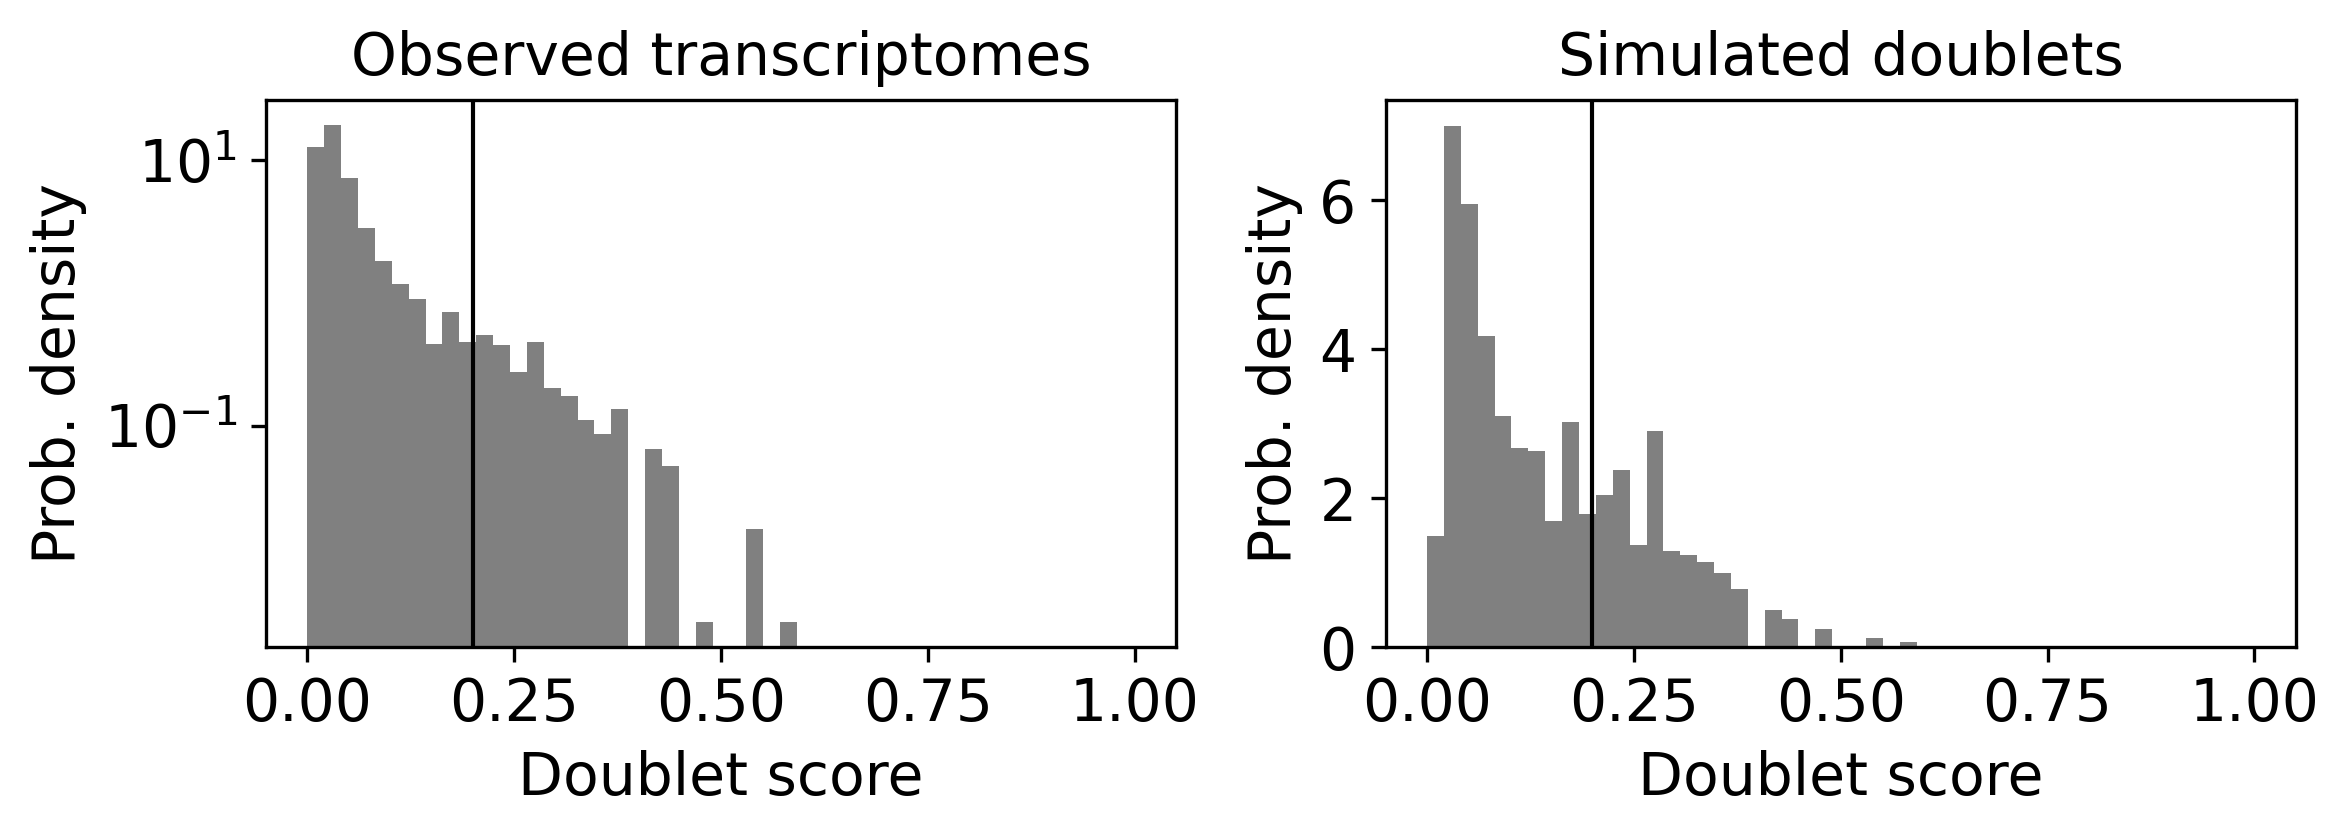

In [6]:
doublet_threshold = 0.2

scrubletPredictions = pd.DataFrame()
for key in adata.obs.batch.unique():
    subsetData = adata[adata.obs.batch == key]
    counts_matrix = subsetData.layers["counts"]
    scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)
    doublet_scores, predicted_doublets = scrub.scrub_doublets(
        min_counts=2, 
        min_cells=3, 
        min_gene_variability_pctl=85, 
        n_prin_comps=30
    )
    scrub.call_doublets(threshold=doublet_threshold)
    scrub.plot_histogram()
    scrubletPrediction = pd.DataFrame({"scrublet_score": doublet_scores}, index=subsetData.obs.index)
    scrubletPredictions = pd.concat([scrubletPredictions, scrubletPrediction])
    
adata.obs["scrublet_score"] = scrubletPredictions.scrublet_score
adata.obs["scrublet_called_doublet"] = adata.obs.scrublet_score > doublet_threshold
num_doublets = adata.obs.scrublet_called_doublet.sum()
pct_doublets = round(num_doublets/len(adata)*100, 3)
print(f"{pct_doublets}% of cells classified as doublets ({num_doublets} cells)")

In [7]:
adata = adata[~adata.obs.scrublet_called_doublet]

# Preprocessing

In [8]:
# Annotate mito genes
adata.var["mt"] = adata.var_names.str.startswith("mt-")
# Get qc metrics for each cell, gene
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True, percent_top=None, log1p=False,)
# Basic prefiltering of empty cells, 0 counts genes
sc.pp.filter_cells(adata, min_genes=1)
sc.pp.filter_genes(adata, min_cells=1)

/tmp/ipykernel_186/2029572420.py:2: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var["mt"] = adata.var_names.str.startswith("mt-")


## QC plotting

### Live view of thresholds

In [9]:
# Inputs for live QC plotting
obs_key="batch" # Key in obs to color data by (if all data is one batch, create an obs column with the same label for all cells
plot_adata=adata

In [10]:
# Colors for each batch
colors=[
        '#1f77b4',  # muted blue
        '#ff7f0e',  # safety orange
        '#2ca02c',  # cooked asparagus green
        '#d62728',  # brick red
        '#9467bd',  # muted purple
        '#8c564b',  # chestnut brown
        '#e377c2',  # raspberry yogurt pink
        '#7f7f7f',  # middle gray
        '#bcbd22',  # curry yellow-green
        '#17becf'   # blue-teal
    ]
# Slider widgets
mt_thresh_slider = widgets.IntSlider(
    value=10,
    min=0,
    max=100,
    step=1.0,
    description='pct_mt:',
    continuous_update=False,
    layout=widgets.Layout(width='750px'),
    style={'description_width': '125px'},
)
total_counts_thresh_slider = widgets.IntSlider(
    value=30000,
    min=0,
    max=adata.obs.total_counts.max(),
    step=250,
    description='total_counts:',
    continuous_update=False,
    layout=widgets.Layout(width='750px'),
    style={'description_width': '125px'},
)
num_genes_thresh_slider = widgets.IntSlider(
    value=7500,
    min=0,
    max=adata.obs.n_genes_by_counts.max(),
    step=100,
    description='n_genes_by_counts:',
    continuous_update=False,
    layout=widgets.Layout(width='750px'),
    style={'description_width': '125px'},
)
# Slider controls widgets
show_thresh_check = widgets.Checkbox(
    description='Show thresholds',
    value=True,
)
reset_button = widgets.Button(
    description="Reset",
    disabled=False,
    tooltip="Reset thresholds",
)


# pct_mt threshold plot
traces = []
for i,category in enumerate(plot_adata.obs[obs_key].unique()):
    subset_adata = plot_adata[plot_adata.obs[obs_key] == category]
    traces.append(
        go.Histogram(
            x=subset_adata.obs.pct_counts_mt,
            marker=dict(
                color=colors[i],
            ),
            name=category,
            legendgroup=category,
        ),
    )
# Setup the layout for the plot and add data
g1 = go.FigureWidget(
    data=traces,
    layout=go.Layout(
        barmode="group",
        plot_bgcolor="rgba(255,255,255,255)",
        width=400,
        height=400,
        xaxis=dict(
            linecolor="black",
            title="pct_counts_mt",
            title_standoff=1,
        ),
        yaxis=dict(
            linecolor="black",
        ),
    )
)
# Add threshold lines
g1.add_vline(
    name="pct_mt",
    x=mt_thresh_slider.value,
    line_dash="dash",
)

# total_counts by num_genes threshold plot
traces = []
for i,category in enumerate(plot_adata.obs[obs_key].unique()):
    subset_adata = plot_adata[plot_adata.obs[obs_key] == category]
    traces.append(
        go.Scatter(
            x=subset_adata.obs.total_counts,
            y=subset_adata.obs.n_genes_by_counts,
            mode="markers",
            marker=dict(
                color=colors[i],
                size=2,
            ),
            name=category,
            legendgroup=category,
        ),
    )
# Setup the layout for the plot and add data
g2 = go.FigureWidget(
    data=traces,
    layout=go.Layout(
        barmode="group",
        plot_bgcolor="rgba(255,255,255,255)",
        width=400,
        height=400,
        xaxis=dict(
            linecolor="black",
            title="total_counts",
            title_standoff=1,
        ),
        yaxis=dict(
            linecolor="black",
            title="n_genes_by_counts",
            title_standoff=1,
        ),
        legend= {'itemsizing': 'constant'},
    )
)
# Add threshold lines
g2.add_vline(
    name="total_counts",
    x=total_counts_thresh_slider.value,
    line_dash="dash",
)
g2.add_hline(
    name="num_genes",
    y=num_genes_thresh_slider.value,
    line_dash="dash",
)

# total_counts by rank (elbow) threshold plot
traces = []
for i,category in enumerate(plot_adata.obs[obs_key].unique()):
    category_data = plot_adata[plot_adata.obs.batch == category].obs.copy()
    category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
    category_data = category_data.sort_values(by="rank")
    traces.append(
        go.Scatter(
            x=category_data["rank"],
            y=category_data.total_counts,
            marker=dict(
                color=colors[i],
            ),
            name=category,
            legendgroup=category,
        ),
    )
# Setup the layout for the plot and add data
g3 = go.FigureWidget(
    data=traces,
    layout=go.Layout(
        barmode="group",
        plot_bgcolor="rgba(255,255,255,255)",
        width=400,
        height=400,
        xaxis=dict(
            linecolor="black",
            title="rank",
            title_standoff=1,
        ),
        yaxis=dict(
            linecolor="black",
            title="total_counts",
            title_standoff=1,
        ),
    )
)
# Add threshold lines
g3.add_hline(
    name="total_counts",
    y=total_counts_thresh_slider.value,
    line_dash="dash",
)
g3.update_layout(yaxis_type = "log")

# Callback method that update the plot threshold lines
def update(change):
    with g1.batch_update():
        for shape in g1["layout"]["shapes"]:
            if shape.name == "pct_mt":
                shape.x0=mt_thresh_slider.value
                shape.x1=mt_thresh_slider.value
            if show_thresh_check.value == True:
                g1.update_shapes(visible=True)
            else:
                g1.update_shapes(visible=False)
    with g2.batch_update():
        for shape in g2["layout"]["shapes"]:
            if shape.name == "total_counts":
                shape.x0=total_counts_thresh_slider.value
                shape.x1=total_counts_thresh_slider.value
            if shape.name == "num_genes":
                    shape.y0=num_genes_thresh_slider.value
                    shape.y1=num_genes_thresh_slider.value
        if show_thresh_check.value == True:
            g2.update_shapes(visible=True)
        else:
            g2.update_shapes(visible=False)
    with g3.batch_update():
        for shape in g3["layout"]["shapes"]:
            if shape.name == "total_counts":
                shape.y0=total_counts_thresh_slider.value
                shape.y1=total_counts_thresh_slider.value
        if show_thresh_check.value == True:
            g3.update_shapes(visible=True)
        else:
            g3.update_shapes(visible=False)
# Callback method that resets the thresholds to defaults
def reset(change):
    total_counts_thresh_slider.value = 30000
    num_genes_thresh_slider.value = 7500
    mt_thresh_slider.value = 10
    update()

# Callback triggers for each widget
mt_thresh_slider.observe(update, names="value")
total_counts_thresh_slider.observe(update, names="value")
num_genes_thresh_slider.observe(update, names="value")
show_thresh_check.observe(update, names="value")
reset_button.on_click(reset)

# layout the plots/widgets
sliders = widgets.VBox(
    children=[mt_thresh_slider, total_counts_thresh_slider, num_genes_thresh_slider],
    layout=widgets.Layout(
        width="1050px",
        display="flex",
        flex_flow="column",
        align_items='center',
    )
)
slider_controls = widgets.HBox(
    children=[reset_button, show_thresh_check],
    layout=widgets.Layout(
        width="1200px",
        display="flex",
        flex_flow="row",
        justify_content='center',
    )
)
plots = widgets.HBox(
    children=[g1,g2,g3],
)

# display the plot/widgets
widgets.VBox(
    [sliders, slider_controls, plots],
)

### QC filter

In [11]:
# Helper method for plotting QC metrics for scrnaseq package
def qc_plot(adata, counts_thresh=30000, genes_thresh=5000, mt_thresh=10, show_thresh=True):
    sns.set_style("ticks")
    sns.set_context("paper")
    fig=plt.figure(figsize=(9,3))
    plt.subplot(1,3,1)
    sns.histplot(
        x=adata.obs.pct_counts_mt,
        hue=adata.obs.batch,
    )
    if show_thresh:
        plt.axvline(
            x=mt_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )

    plt.subplot(1,3,2)
    sns.scatterplot(
        x=adata.obs.total_counts,
        y=adata.obs.n_genes_by_counts,
        s=2,
        hue=adata.obs.batch,
        linewidth=0,
    )
    if show_thresh:
        plt.axvline(
            x=counts_thresh,
            ymin=0,
            ymax=1,
            color="black",
            linestyle="--",
        )
        plt.axhline(
            y=genes_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    plt.subplot(1,3,3)
    cell_data = pd.DataFrame()
    for category in adata.obs.batch.unique():
        category_data = adata[adata.obs.batch == category].obs.copy()
        category_data["rank"] = category_data.total_counts.rank(method="first", ascending=False,)
        cell_data = pd.concat([cell_data, category_data])
    cell_data = cell_data.sort_values(by="rank")
    ax =sns.lineplot(
        x=cell_data["rank"],
        y=cell_data.total_counts,
        hue=cell_data.batch,
        hue_order=adata.obs.batch.unique(),
    )
    ax.set(yscale="log")
    if show_thresh:
        plt.axhline(
            y=counts_thresh,
            xmin=0,
            xmax=1,
            color="black",
            linestyle="--",
        )
    fig.tight_layout()
    plt.show()

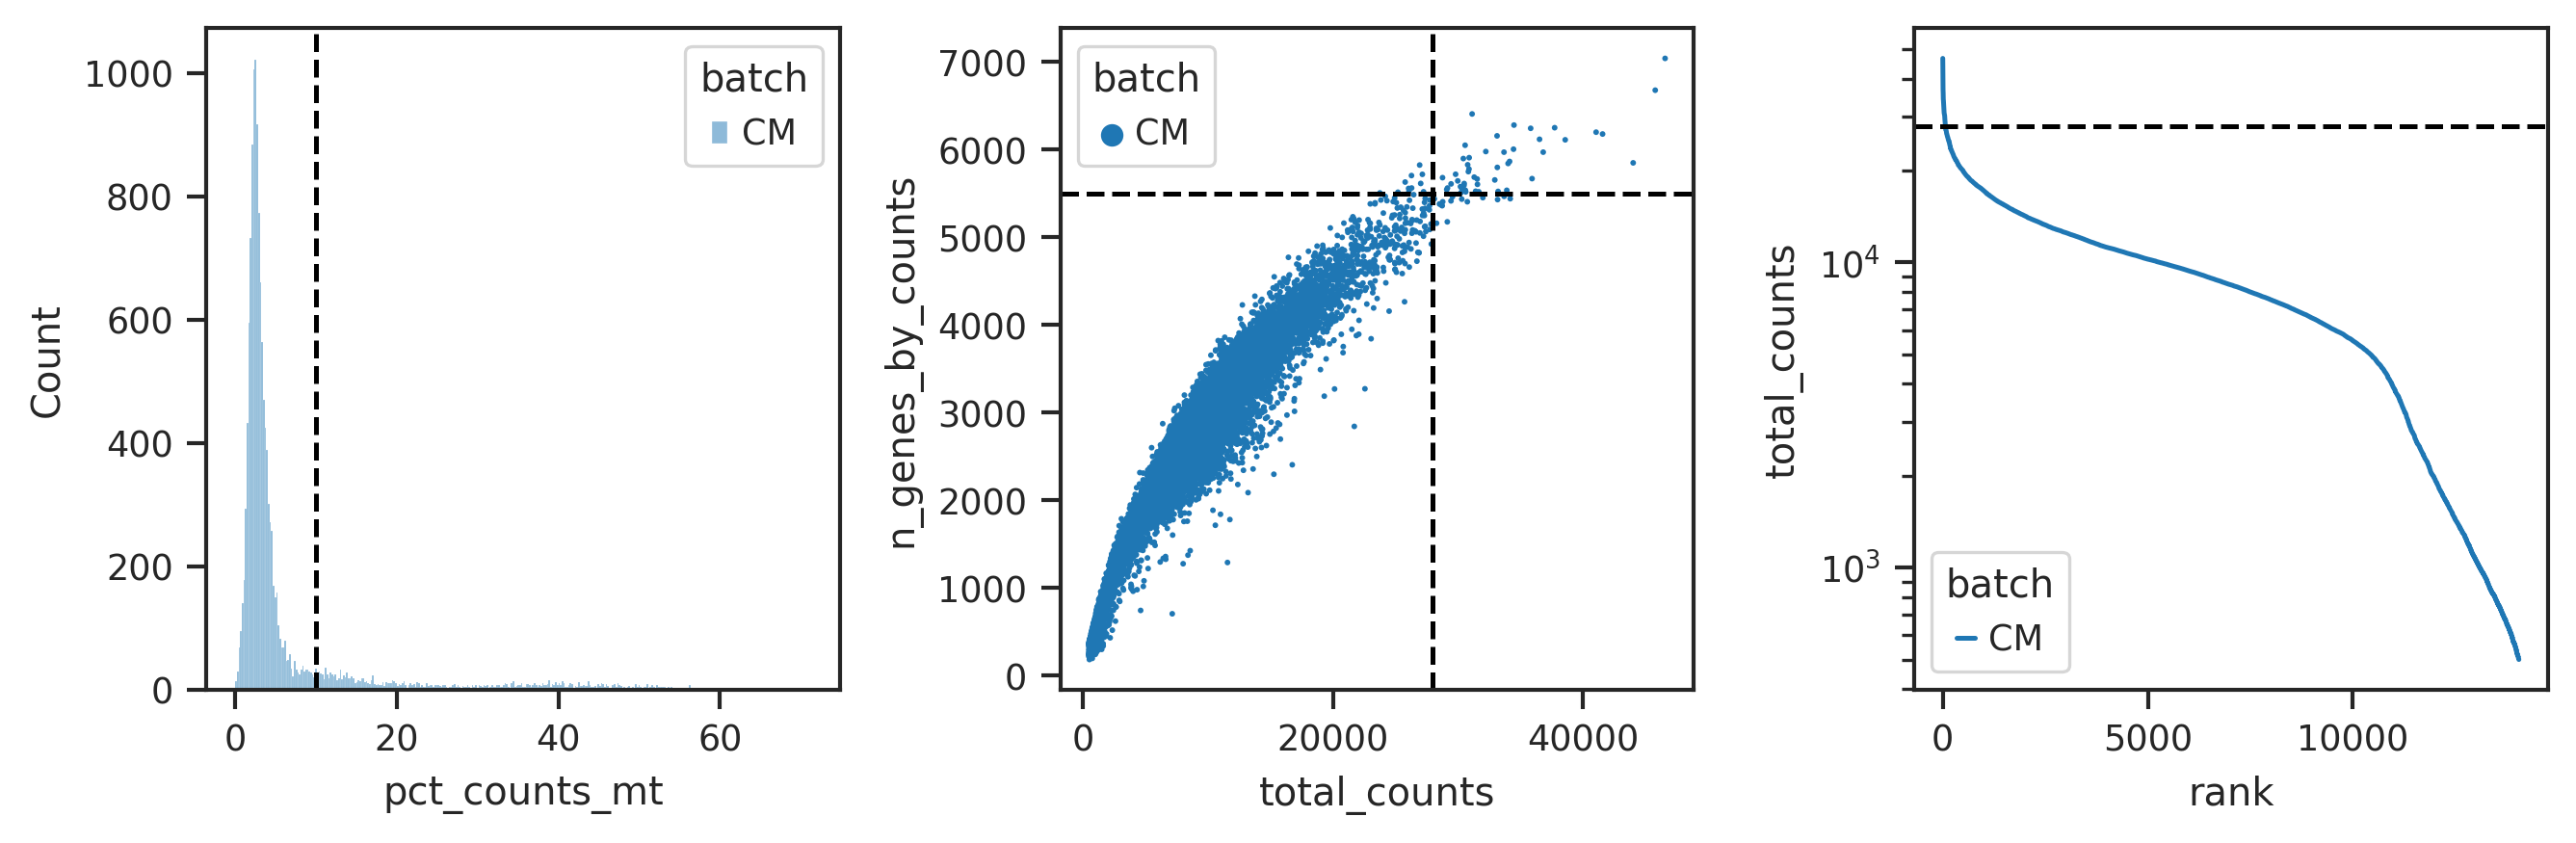

In [12]:
# save a copy of the unfiltered data
adataUnfiltered = adata.copy()

# Set thresholds
totalCountsThreshold = 28000
numGenesThreshold = 5500
mtThreshold = 10

# Check QC thresholds before filtering
qc_plot(adata, totalCountsThreshold, numGenesThreshold, mtThreshold)

In [13]:
# Filter cells based on thresholds
adataFiltered = adata[adata.obs.pct_counts_mt <= mtThreshold].copy()
adataFiltered = adataFiltered[adataFiltered.obs.total_counts <= totalCountsThreshold]
adataFiltered = adataFiltered[adataFiltered.obs.total_counts >= 1000]
adataFiltered = adataFiltered[adataFiltered.obs.n_genes_by_counts <= numGenesThreshold]
adataFiltered = adataFiltered[adataFiltered.obs.n_genes_by_counts >= 500]

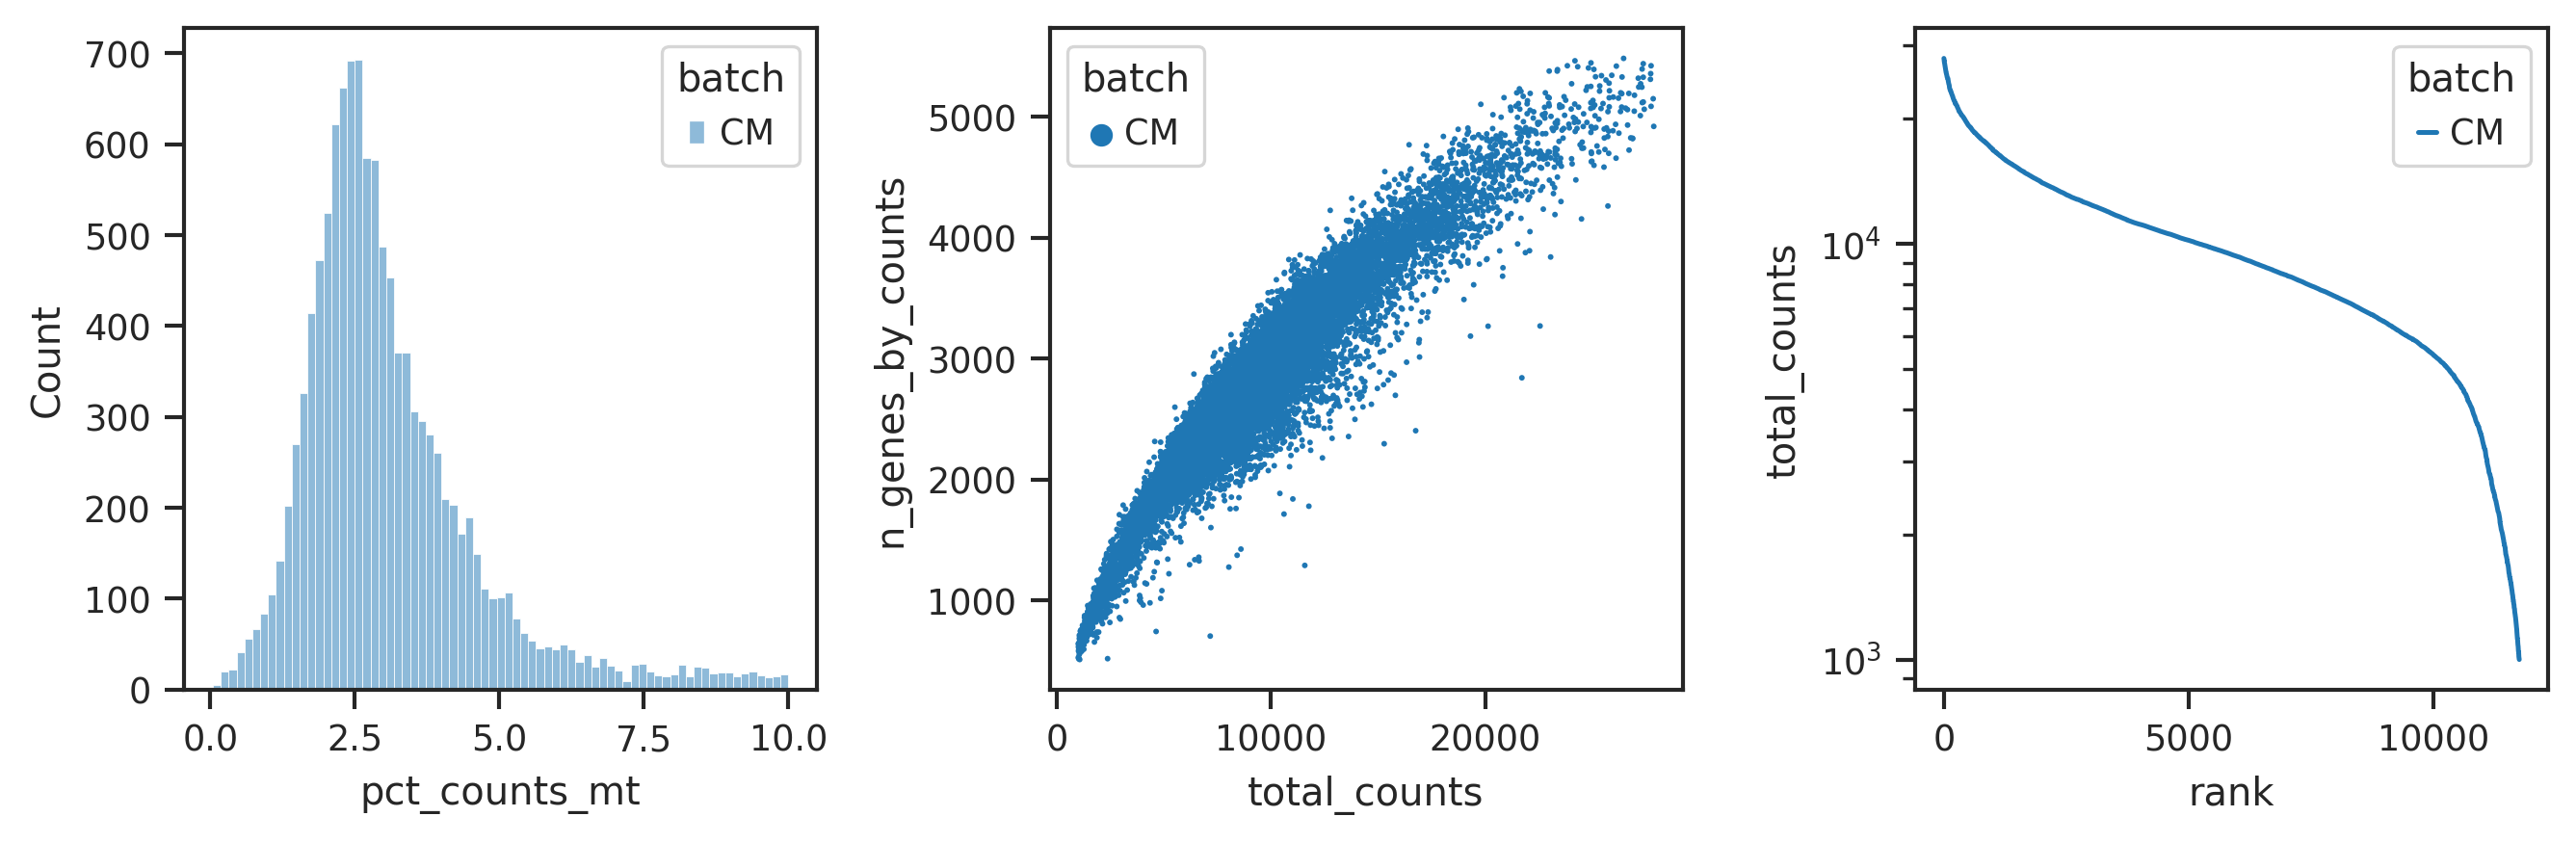

In [14]:
qc_plot(adataFiltered, show_thresh=False)

In [15]:
# overwrite original adata variable with the filtered data
adata = adataFiltered

# Clean up to save memory 
del adataFiltered

In [16]:
adata

View of AnnData object with n_obs × n_vars = 11748 × 21570
    obs: 'batch', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    layers: 'counts'

## Normalize data (scanpy)

In [17]:
# Scanpy preprocessing pipeline
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # Preserve log-transformed counts in the raw attribute

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning:

Received a view of an AnnData. Making a copy.



## Get HVGs

In [18]:
# Get HVGs to train on
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=3000,
    subset=False,
    layer="counts",
    flavor="seurat_v3",
    batch_key="batch"
)

# Add in non HVGs to be analyzed
genesToKeep = ["Aire", "Pou2f3", "Foxj1",  "Ccl21a", "Mki67", "Tspan8", "Gp2", "Krt10", "Ascl1", "Ccl9", "Spib", "Tnfaip2", "Siglecf", "Ccl6", "Sox8", "Pglyrp1", "Tnfrsf9", "Ccl20", "Tnfrsf11a",
               "Tnfrsf11b", "Psmb11", "Foxn1", "Epcam", "Tnfsf13b"]
adata.var["genes_to_keep"] = adata.var.highly_variable
for gene in genesToKeep:
    if gene not in adata.var_names:
        print(f"{gene} is not a gene in adata")
    adata.var.loc[adata.var.index == gene, "genes_to_keep"] = True
    
# Subset on genes to keep
adata = adata[:,adata.var.genes_to_keep]

In [21]:
adata

View of AnnData object with n_obs × n_vars = 11748 × 3011
    obs: 'batch', 'scrublet_score', 'scrublet_called_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'genes_to_keep'
    uns: 'log1p', 'hvg'
    layers: 'counts'

## Regress covariates and scale

In [22]:
# Finish scanpy preprocessing pipeline
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning:

Trying to modify attribute `.obs` of view, initializing view as actual.

/opt/conda/lib/python3.8/site-packages/anndata/_core/anndata.py:1235: ImplicitModificationWarning:

Trying to modify attribute `.var` of view, initializing view as actual.



# scVI training

In [23]:
# Setup scVI model using raw counts and batch info
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key="batch",
)
model = scvi.model.SCVI(adata)

In [24]:
# Train scVI model
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|          | 0/400 [00:00<?, ?it/s]

/opt/conda/lib/python3.8/site-packages/scvi/distributions/_negative_binomial.py:61: UserWarning:

Specified kernel cache directory could not be created! This disables kernel caching. Specified directory is /root/.cache/torch/kernels. This warning will appear only once per process. (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/cuda/jit_utils.cpp:860.)



Epoch 400/400: 100%|██████████| 400/400 [05:32<00:00,  1.20it/s, loss=1.27e+03, v_num=1]


In [25]:
# Checl save paths
if not os.path.isdir("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/"):
    os.makedirs("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/")
    
if not os.path.isdir("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/"):
    os.makedirs("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/")
    
if os.path.isdir("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/WT_CM_3011_genes"):
    shutil.rmtree("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/WT_CM_3011_genes")
    
# save the scVI model and adata object before further processing because training is non-deterministic
model.save("/notebook/External/Archive/Joe/processed_data/M_cell/scVI_models/WT_CM_3011_genes")
adata.write("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/WT_CM_3011_genes.h5ad")

In [26]:
# get scVI latent space and normalized expression
adata.obsm["X_scVI"] = model.get_latent_representation()
adata.layers["scVI_normalized"] = model.get_normalized_expression(library_size=1e4)

# Dimensionality reduction

In [27]:
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.25,)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


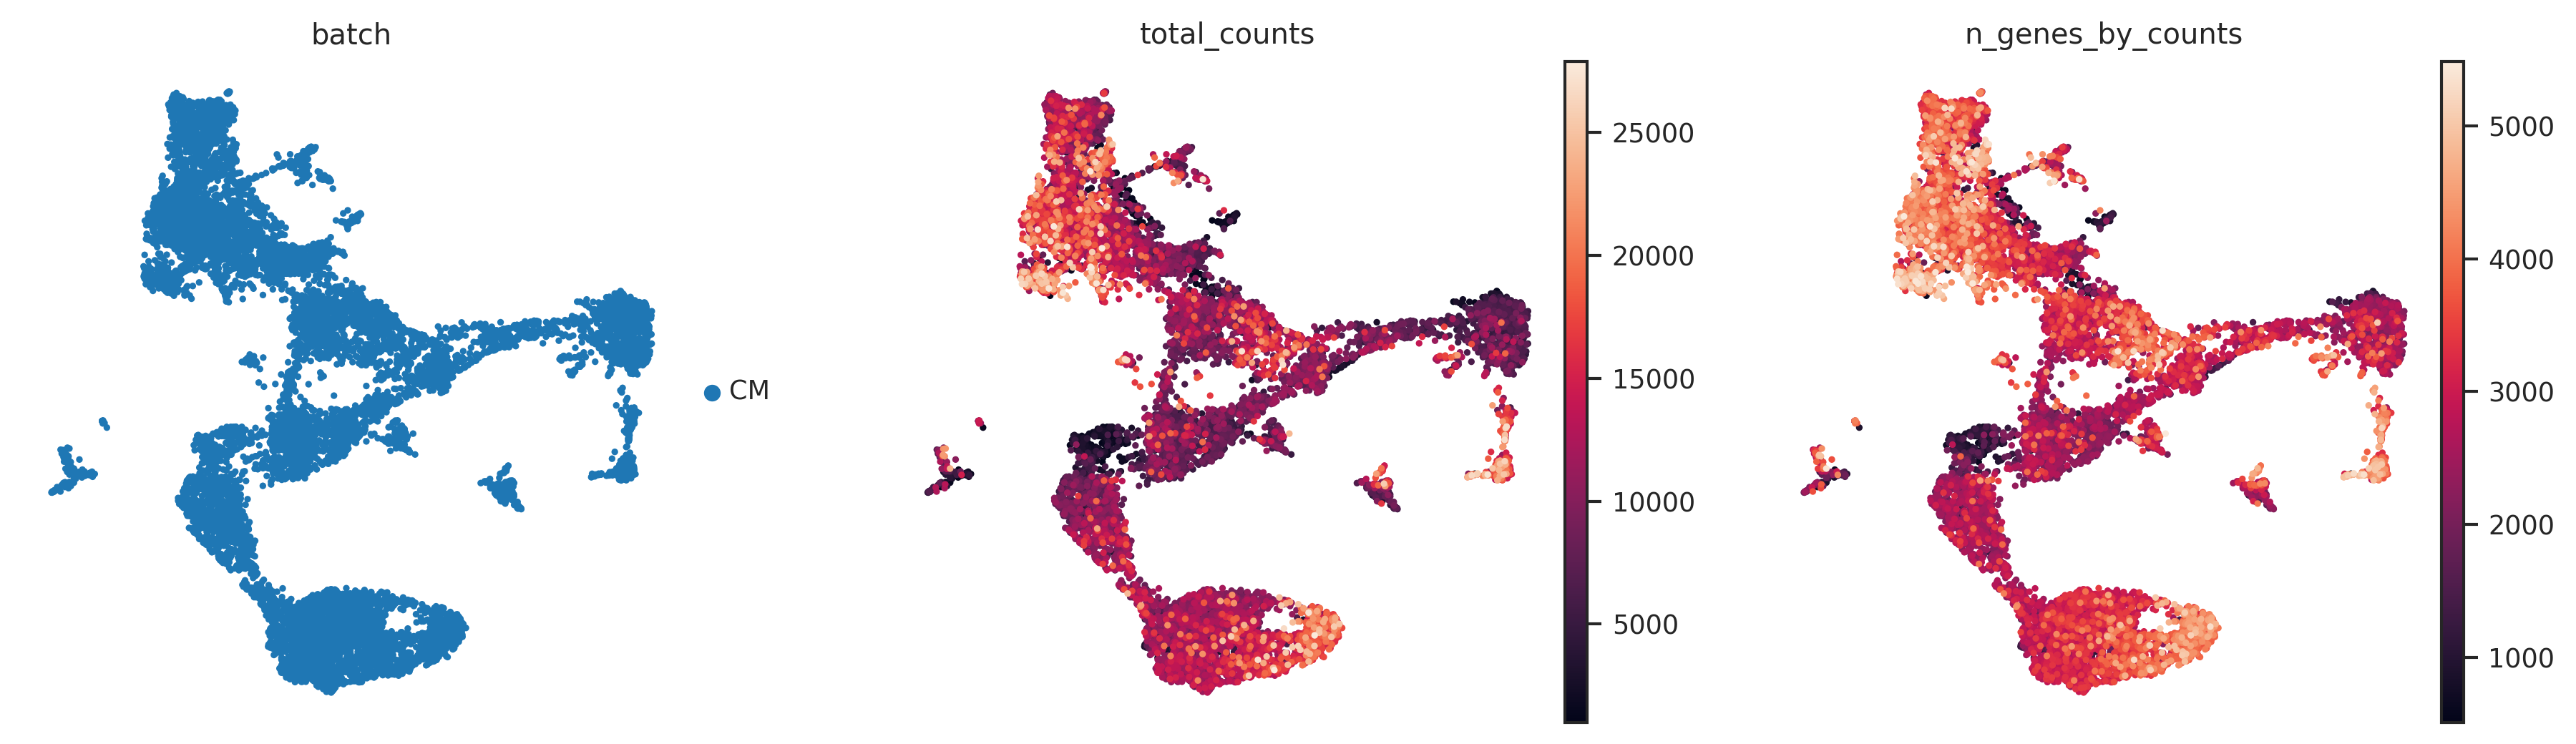

In [28]:
# Check dimensionality reduction for batch effects
sc.pl.umap(
    adata,
    color=["batch", "total_counts", "n_genes_by_counts"],
    s=20,
)

# Clustering

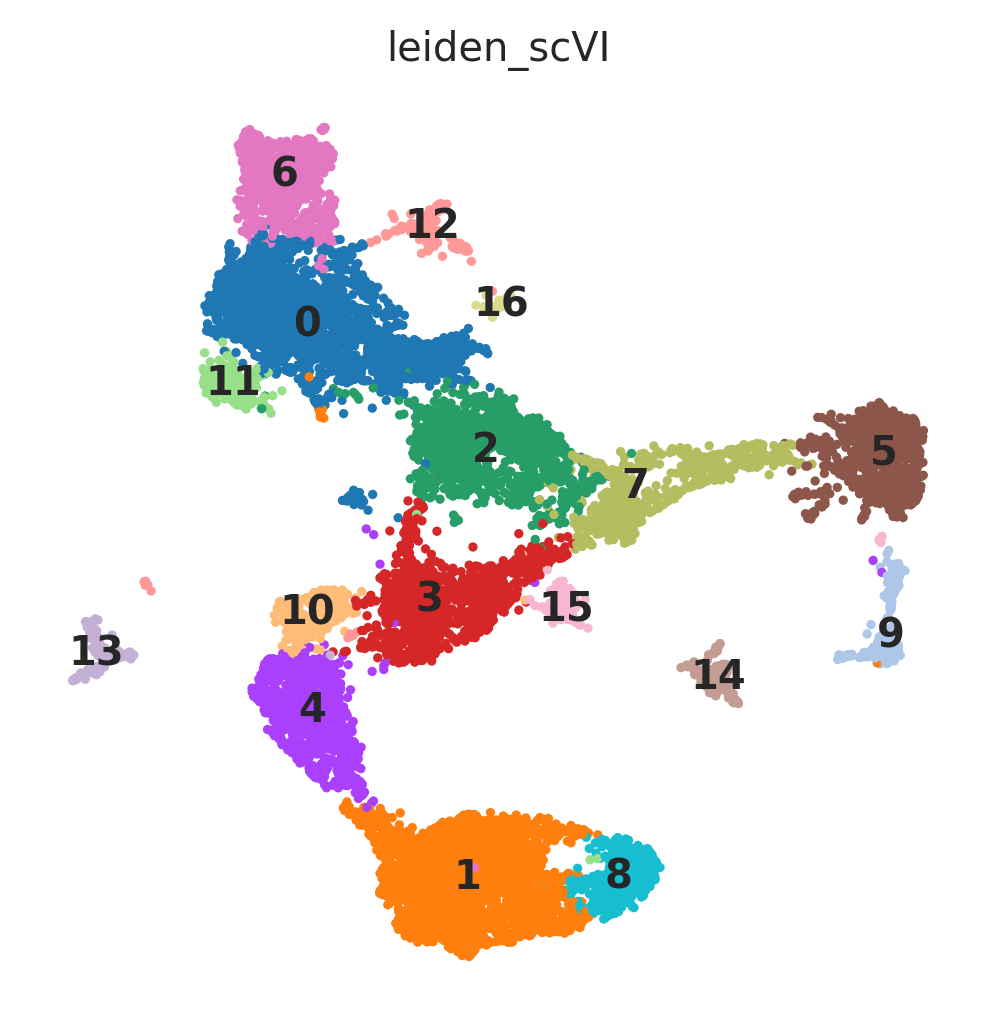

In [29]:
sc.tl.leiden(adata, key_added="leiden_scVI", resolution=0.5)
sc.pl.umap(
    adata,
    color=["leiden_scVI"],
    legend_loc="on data",
    s=20,
)

# Cell Type Assignment

/opt/conda/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning:

Trying to modify attribute `._uns` of view, initializing view as actual.



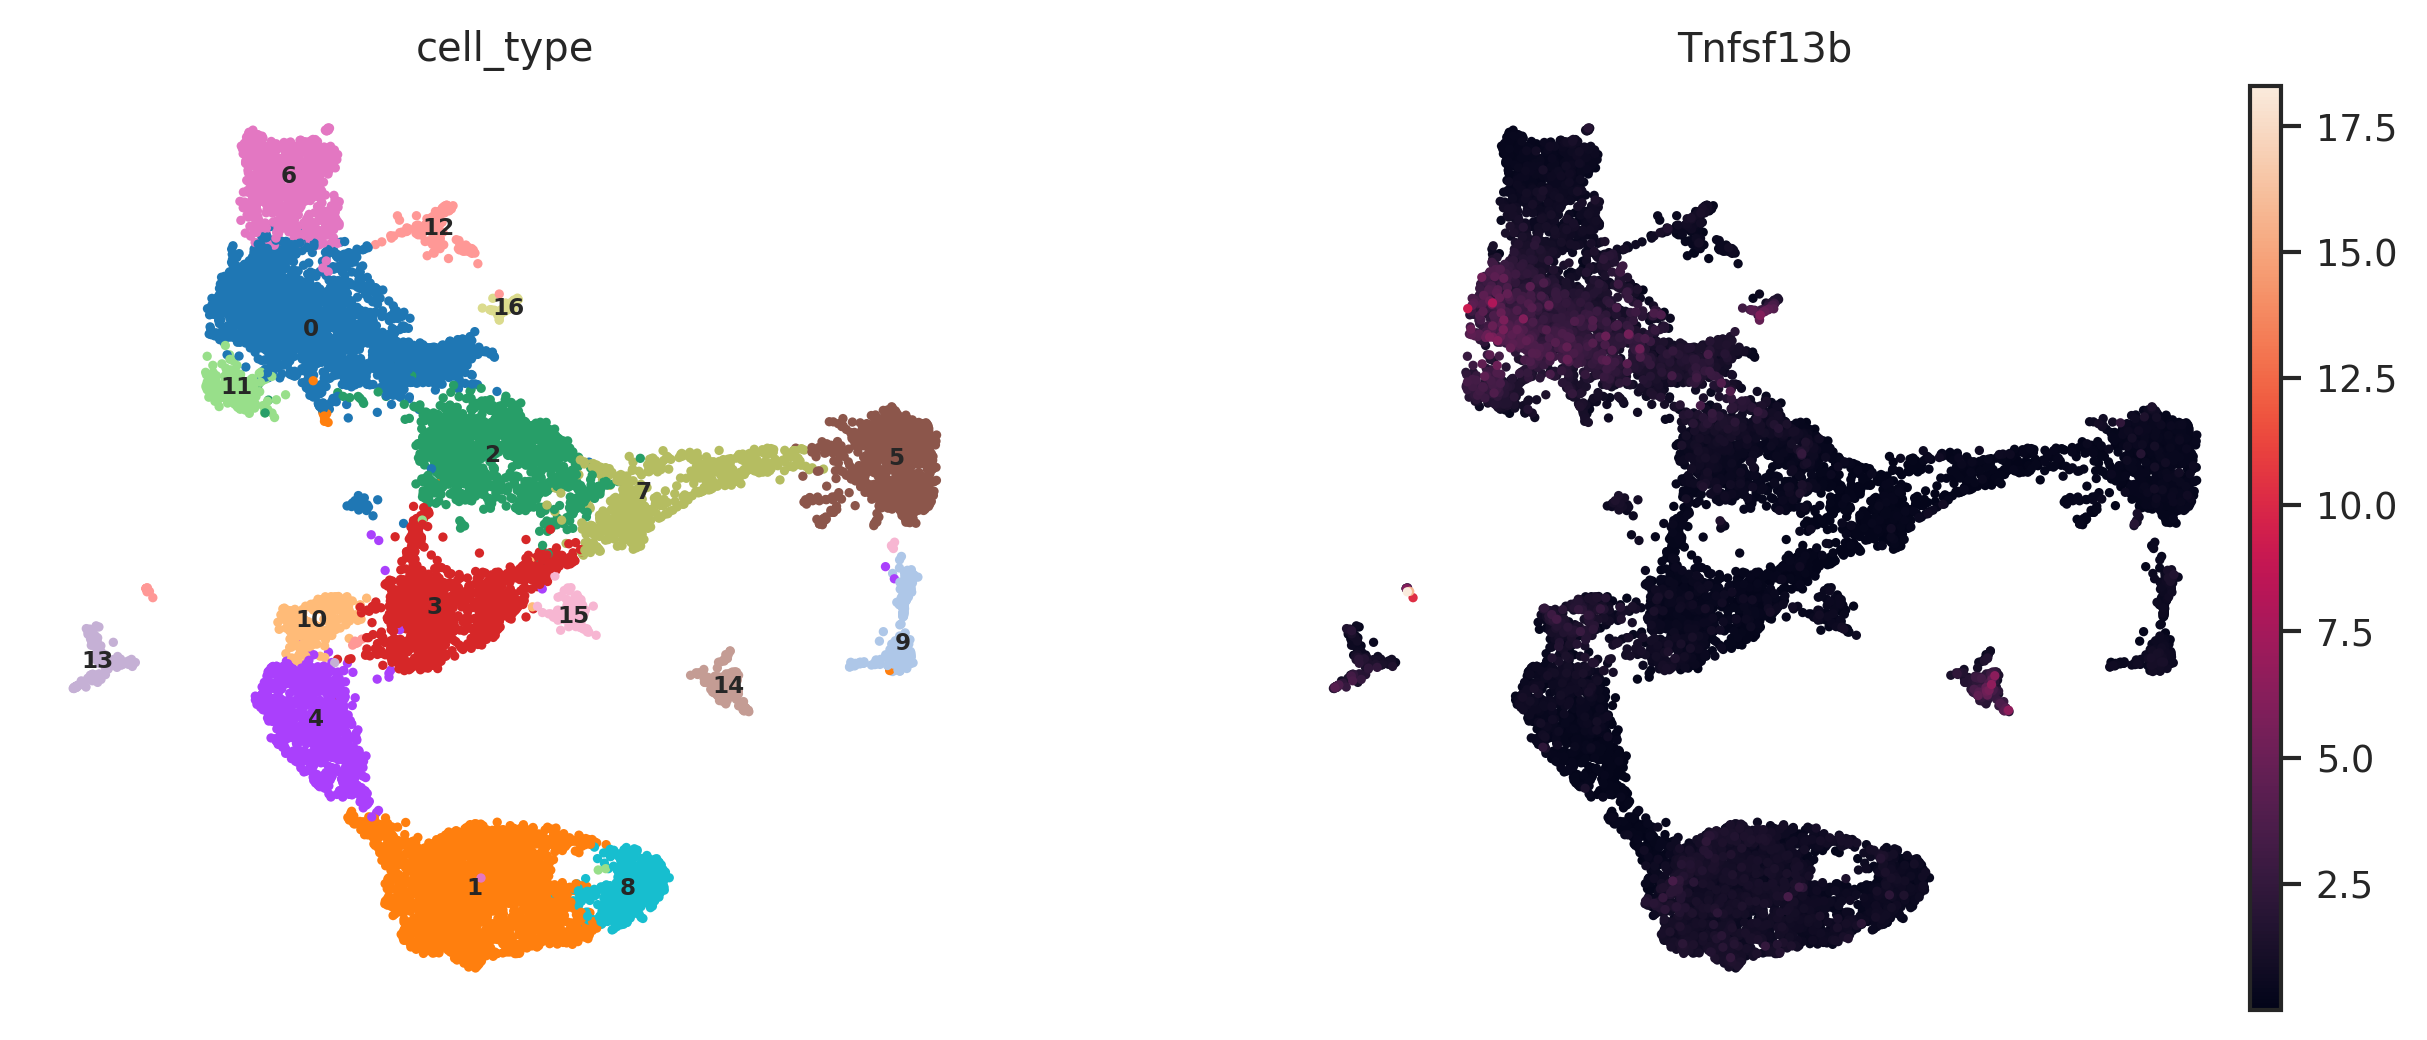

In [31]:
# Rename leiden clusters with corresponding cell types
cellTypes = {

}
adata.obs["cell_type"] = adata.obs.leiden_scVI.replace(cellTypes)

# Filter non mTECs/Junk clusters
adata = adata[~adata.obs.cell_type.isin([])]

# Plot key marker genes
sc.pl.umap(
    adata,
    color=["cell_type", "Tnfsf13b"],
    legend_loc="on data",
    layer="scVI_normalized",
    legend_fontsize="xx-small",
    s=20,
)

# Save Anndata

In [32]:
adata.write("/notebook/External/Archive/Joe/processed_data/M_cell/h5ad_files/WT_CM_3011_genes.h5ad")